# AutoML Homework 1

## Filip Skrzeczkowski
## Filip Suchorab

## Wstępna konfiguracja
----
Importy pakietów i sporządzenie listy wykorzystywanych zbiorów danych

In [3]:
import openml
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer, make_column_selector, ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
import numpy as np
import pandas as pd

# datasets
datasets = [31, 1464, 37, 1479]

In [4]:
def pipeline_with_model(classifier):
    num_pipeline = Pipeline(steps=[
    ('impute', SimpleImputer(strategy='mean')),
    ('scale', MinMaxScaler())])

    cat_pipeline = Pipeline(steps=[
        ('impute', SimpleImputer(strategy='most_frequent')),
        ('one-hot', OneHotEncoder(handle_unknown='ignore', sparse=False))
    ])

    col_trans = ColumnTransformer(transformers=[
    ('num_pipeline',num_pipeline, make_column_selector( dtype_include= np.number)),
    ('cat_pipeline',cat_pipeline, make_column_selector( dtype_include= np.object_))
    ],
    remainder='drop',
    n_jobs=-1)
    return Pipeline([('preprocessing', col_trans), ('model', classifier)])

## Random Search
----

In [ ]:
# Random forest
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(5, 100, num=100)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 50)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [int(x) for x in np.linspace(2, 50)]
# Minimum number of samples required at each leaf node
min_samples_leaf = [int(x) for x in np.linspace(1, 50)]
# Create the random grid
random_grid = {'model__n_estimators': n_estimators,
               'model__max_depth': max_depth,
               'model__min_samples_split': min_samples_split,
               'model__min_samples_leaf': min_samples_leaf}

rf_pipeline = pipeline_with_model(RandomForestClassifier(random_state=42))

# SVM
from sklearn.svm import SVC
svm_grid = {'model__C': np.logspace(-10, 10, num=1000, base=2),
              'model__gamma': np.logspace(-10, 0, num=1000, base=2)}
svm_pipeline = pipeline_with_model(SVC())

# K nearest neighbors 
k_neighbors_pipeline = pipeline_with_model(KNeighborsClassifier())
k_neighbors_params = {'model__n_neighbors': [int(x) for x in np.linspace(2, 500, num = 500)]}

classifiers = {
    # "random_forest": {"estimator" : rf_pipeline, "params": random_grid },
    # "svm": {"estimator" : svm_pipeline, "params": svm_grid },
    "k_neighbors": {"estimator": k_neighbors_pipeline, "params": k_neighbors_params}
}

for key, classifier in classifiers.items():
    random = RandomizedSearchCV(estimator = classifier['estimator'], param_distributions = classifier['params'], n_iter = 500, cv = 3, 
                               verbose=10, random_state=42, n_jobs = -1, scoring='roc_auc')
    with pd.ExcelWriter(f"Random_Search_{key}_result.xlsx") as writer:
        for index in datasets:
            dataset = openml.datasets.get_dataset(index)

            # Get the data itself as a dataframe
            data, *_ = dataset.get_data(dataset_format="dataframe")
            try:
                y = data['class']
                X = data.drop('class', axis=1)
            except:
                y = data['Class']
                X = data.drop('Class', axis=1)
            search = random.fit(X, y)
            result = pd.DataFrame(search.cv_results_)
            result.to_excel(writer, sheet_name=f"Dataset_{index}")
        writer.close

Analyze the data

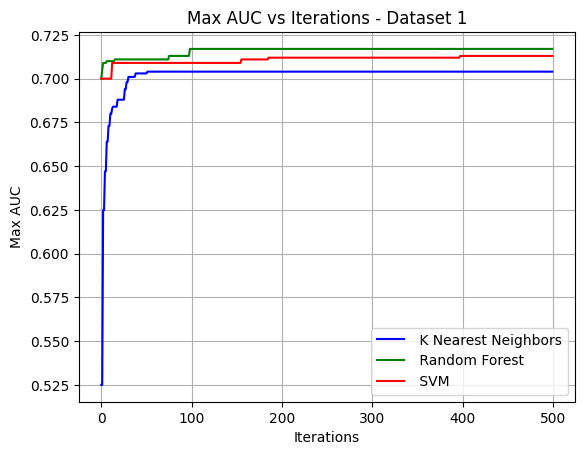

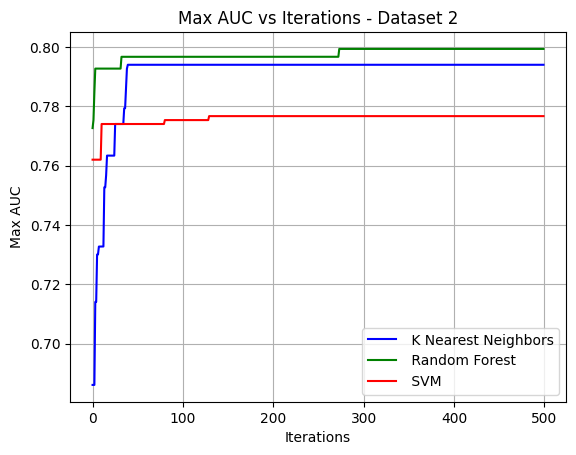

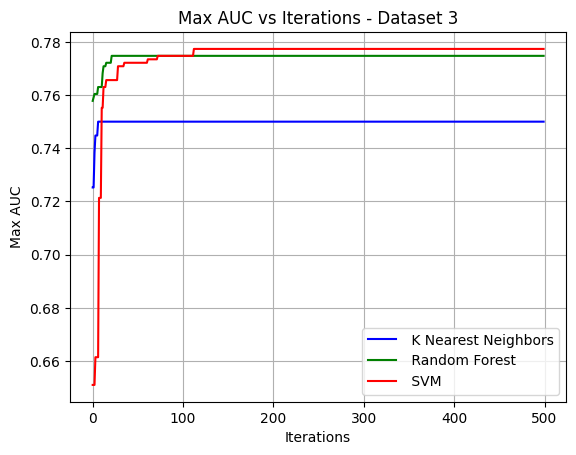

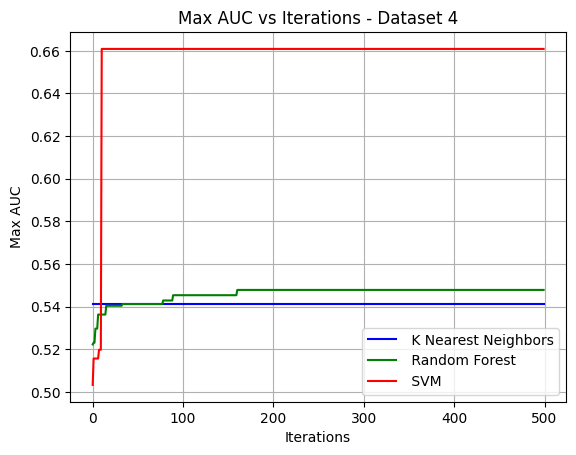

In [31]:
import matplotlib.pyplot as plt
from IPython.display import display

# load data from excel files
excel_files = [('Random_Search_k_neighbors_result.xlsx', 'k_neighbors'), 
               ('Random_Search_random_forest_result.xlsx', 'random_forest'), 
               ('Random_Search_svm_result.xlsx', 'SVM')]

# get average score from all datasets
dataframes = {}
for file, name in excel_files:
    df1 = pd.read_excel(file, sheet_name = 0, usecols = ['params','mean_test_score'])
    df2 = pd.read_excel(file, sheet_name = 1, usecols = ['params','mean_test_score'])
    df3 = pd.read_excel(file, sheet_name = 2, usecols = ['params','mean_test_score'])
    df4 = pd.read_excel(file, sheet_name = 3, usecols = ['params','mean_test_score'])
    dfs = [df1, df2, df3, df4]
    result_df = pd.concat(dfs, ignore_index=True).groupby('params').mean().reset_index()
    del df1, df2, df3, df4
    dataframes[name] = result_df

# find average best score
best_params_df = pd.DataFrame(columns=['Algorithm', 'avg_auc', 'best_params'])
for algorithm, df in dataframes.items():
    max_auc_index = df['mean_test_score'].idxmax()
    row_with_max_auc = df.loc[max_auc_index]
    auc = row_with_max_auc.loc["mean_test_score"]
    best_params = row_with_max_auc.loc["params"]

    best_params_df = pd.concat([best_params_df, pd.DataFrame({'Algorithm': algorithm,
                              'avg_auc': [auc], 
                              'best_params': [best_params]})], ignore_index = True)

tunability_df = pd.DataFrame(columns=['Algorithm', 'Dataset', 'Tunability', 'best_auc', 'best_params'])
# count tunability per dataset
for file, name in excel_files:
    for i in range(4):
        df = pd.read_excel(file, sheet_name = i, usecols = ['params','mean_test_score'])
        max_auc_index = df['mean_test_score'].idxmax()
        row_with_max_auc = df.loc[max_auc_index]
        best_auc_on_dataset = row_with_max_auc.loc['mean_test_score']
        best_params_on_dataset = row_with_max_auc.loc['params']

        best_params_row = best_params_df[best_params_df['Algorithm'] == name]
        best_params = best_params_row.loc[:, 'best_params'].iloc[0]
        best_auc = df[df['params'] == best_params].iloc[0]['mean_test_score']
        tunability = best_auc_on_dataset - best_auc
        tunability_df = pd.concat([tunability_df, pd.DataFrame({'Algorithm': name, 
                              'Dataset': [i], 
                              'Tunability': [tunability], 
                              'best_auc': [best_auc_on_dataset], 
                              'best_params': [best_params_on_dataset]})], ignore_index = True)
        
names = ['K Nearest Neighbors', 'Random Forest', 'SVM']
for j in range(4):
    max_scores_list = []
    for file, name in excel_files:
        # plots
        df = pd.read_excel(file, sheet_name = j, usecols = ['mean_test_score'])
        iterations = df.index.tolist()
        max_scores = []
        # Iterate over rows and track the maximum 'mean_test_score'
        max_score_so_far = float('-inf')
            # Iterate over rows in each DataFrame and track the maximum 'mean_test_score'
        for _, row in df.iterrows():
            max_score_so_far = max(max_score_so_far, row['mean_test_score'])
            max_scores.append(max_score_so_far)
        max_scores_list.append(max_scores)
    colors = ['b', 'g', 'r', 'c']
    for i, max_scores in enumerate(max_scores_list):
        plt.plot(iterations, max_scores, linestyle='-', color=colors[i], label=f' {names[i]}')
    plt.xlabel('Iterations')
    plt.ylabel('Max AUC')
    plt.title(f'Max AUC vs Iterations - Dataset {j + 1}')
    plt.legend()
    plt.grid(True)
    plt.show()

In [32]:
pd.set_option('max_colwidth', 800)
print("Best hyperparameters")
display(best_params_df)

Best hyperparameters


,Algorithm,avg_auc,best_params
0,k_neighbors,0.685557,{'model__n_neighbors': 44}
1,random_forest,0.702092,"{'model__n_estimators': 84, 'model__min_samples_split': 42, 'model__min_samples_leaf': 5, 'model__max_depth': 20}"
2,SVM,0.722859,"{'model__gamma': 0.1704531832457448, 'model__C': 694.3115877932968}"


In [33]:
print("Tunability")
tunability_df

Tunability


,Algorithm,Dataset,Tunability,best_auc,best_params
0,k_neighbors,0,0.002005,0.704003,{'model__n_neighbors': 52}
1,k_neighbors,1,0.006667,0.794062,{'model__n_neighbors': 40}
2,k_neighbors,2,0.026042,0.750000,{'model__n_neighbors': 7}
3,k_neighbors,3,0.012376,0.541254,{'model__n_neighbors': 2}
4,random_forest,0,0.010999,0.716992,"{'model__n_estimators': 43, 'model__min_samples_split': 27, 'model__min_samples_leaf': 4, 'model__max_depth': 8}"
5,random_forest,1,0.010645,0.799411,"{'model__n_estimators': 33, 'model__min_samples_split': 19, 'model__min_samples_leaf': 30, 'model__max_depth': 16}"
6,random_forest,2,0.006510,0.774740,"{'model__n_estimators': 54, 'model__min_samples_split': 28, 'model__min_samples_leaf': 3, 'model__max_depth': 6}"
7,random_forest,3,0.002475,0.547855,"{'model__n_estimators': 88, 'model__min_samples_split': 32, 'model__min_samples_leaf': 2, 'model__max_depth': 9}"
8,SVM,0,0.003003,0.712988,"{'model__gamma': 0.23781768823411079, 'model__C': 90.29013703727496}"
9,SVM,1,0.000000,0.776734,"{'model__gamma': 0.15683585539078018, 'model__C': 765.1398109464636}"


## Optymalizacja bayesowska
----

In [8]:
from skopt.space import Real, Integer

# Define hyperparameter space for each algorithm

space_rf  = [Integer(1, 100, name='n_estimators'),
          Integer(1, 50, name='max_depth'),
          Integer(2, 50, name='min_samples_split'),
          Integer(1, 50, name='min_samples_leaf')]

space_svm  = [Real(0.00001, 1000, name='C'),
              Real(0.00001, 1000, name='gamma')]

space_kn  = [Integer(1, 100, name='n_neighbors')]

# Declare datasets - the actual data reading is postponed until the main loop
# (a possible optimization in case of large datasets)

y_train = []
X_train = []
y_test = []
X_test = []

# Initialize outputarrays
r_bayes_rf = []
r_bayes_svm = []
r_bayes_kn = []

theta_bayes_rf_auc = []
theta_bayes_svm_auc = []
theta_bayes_kn_auc = []

# Create classifiers

from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

rf = RandomForestClassifier(random_state=1)
svm = SVC(random_state=1)
kn = KNeighborsClassifier()


In [9]:
from skopt.utils import use_named_args
from sklearn.metrics import roc_auc_score, accuracy_score

# Helper function - fits the model and returns its score

def to_opt(model, arr):
    model_pipeline = pipeline_with_model(model)
    model_pipeline.fit(X_train, y_train)
    result = model_pipeline.predict(X_test)
    score = roc_auc_score(y_test, result)
    arr.append(score)
    return -score

# Define optimization objectives for each algorithm

@use_named_args(space_rf)
def optimize_rf(**params):
    rf.set_params(**params)
    return to_opt(rf, theta_bayes_rf_auc)

@use_named_args(space_svm)
def optimize_svm(**params):
    svm.set_params(**params)
    return to_opt(svm, theta_bayes_svm_auc)

@use_named_args(space_kn)
def optimize_kn(**params):
    kn.set_params(**params)
    return to_opt(kn, theta_bayes_kn_auc)


In [51]:
from skopt import gp_minimize
from skopt.learning import GaussianProcessRegressor
from skopt.learning.gaussian_process.kernels import ConstantKernel, Matern
np.int = np.int64

maxIters = 50

# Optimization function called for every algorithm
def optimize(fun, space):

    noise = 0.2
    m52 = ConstantKernel(1.0) * Matern(length_scale=1.0, nu=2.5)
    gpr = GaussianProcessRegressor(kernel=m52, alpha=noise**2)

    r = gp_minimize(fun,
                    space,
                    base_estimator=gpr,
                    acq_func='EI',      # expected improvement
                    xi=0.01,            # exploitation-exploration trade-off
                    n_calls=maxIters,         # number of iterations
                    n_random_starts=15,
                    random_state=1,
                    n_jobs=-1
                    )

    gpr.fit(r.x_iters, -r.func_vals)

    return r

/home/filip/.local/lib/python3.10/site-packages/openml/datasets/functions.py:438: FutureWarning: Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.
  warnings.warn(
/home/filip/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/filip/.local/lib/python3.10/site-packages/sklearn/gaussian_process/kernels.py:430: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__length_scale is close to the specified upper bound 100000.0. 

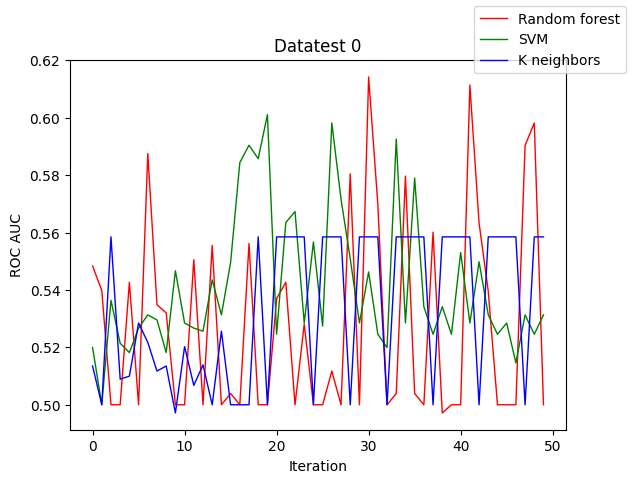

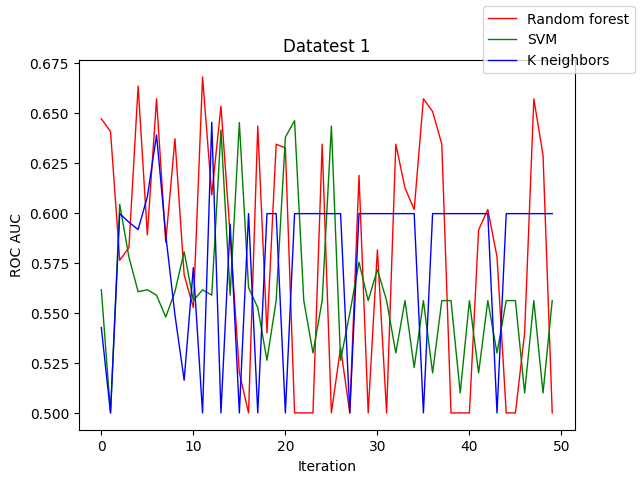

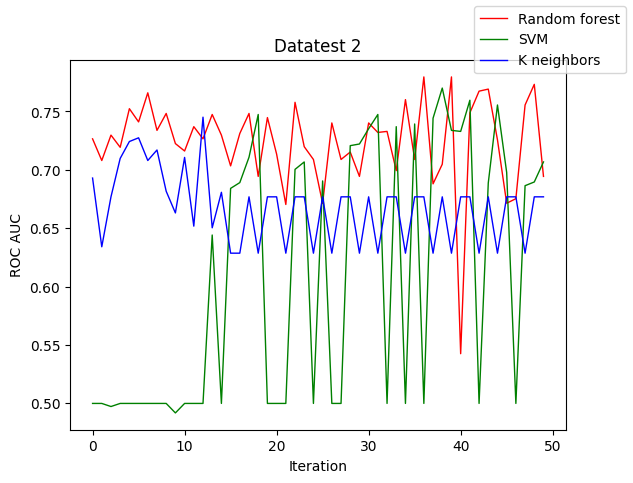

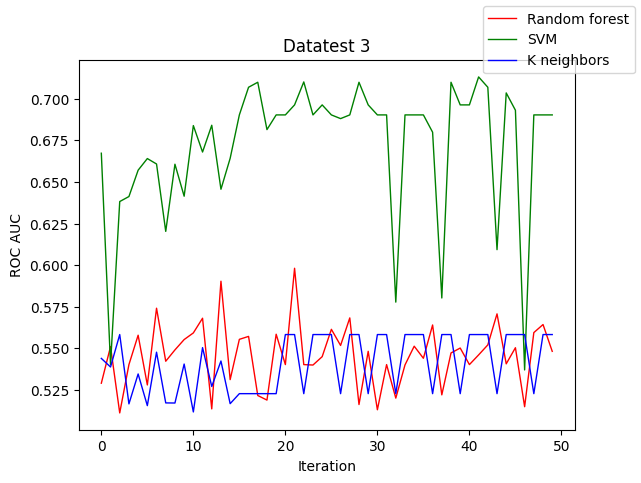

In [52]:
import matplotlib.pyplot as plt

## BAYES OPTIMIZATION

# Main loop over datasets
for i in range(0, len(datasets)):
    dataset = openml.datasets.get_dataset(datasets[i])

    # Get the data itself as a dataframe
    data, *_ = dataset.get_data(dataset_format="dataframe")
    data.head()

    train, test = train_test_split(data, test_size=0.25, random_state=1)

    try:
        y_train = train['class']
        X_train = train.drop('class', axis=1)
        y_test = test['class']
        X_test = test.drop('class', axis=1)
    except:
        y_train = train['Class']
        X_train = train.drop('Class', axis=1)
        y_test = test['Class']
        X_test = test.drop('Class', axis=1)

    # Manually change strings to numeric values (surely there must be a better way)
    first = y_train.iloc[0]
    if isinstance(first, str):
        second = first
        for v in y_train:
            if v is not first:
                second = v
                break

        mapping = {
            first: 0,
            second: 1
        }
        y_train = y_train.map(mapping)
        y_test = y_test.map(mapping)

    ## Optimize for each algorithm
    fig = plt.figure(i)
    theta_bayes_rf_auc = []
    theta_bayes_svm_auc = []
    theta_bayes_kn_auc = []

    # random forest
    r_bayes_rf.append(optimize(optimize_rf, space_rf))
    plt.plot(range(0, maxIters), theta_bayes_rf_auc, 'r-', lw=1, label='Random forest')

    # SVM
    r_bayes_svm.append(optimize(optimize_svm, space_svm))
    plt.plot(range(0, maxIters), theta_bayes_svm_auc, 'g-', lw=1, label='SVM')

    # k neighbors
    r_bayes_kn.append(optimize(optimize_kn, space_kn))
    plt.plot(range(0, maxIters), theta_bayes_kn_auc, 'b-', lw=1, label='K neighbors')

    plt.xlabel("Iteration")
    plt.ylabel("ROC AUC")
    plt.title(f"Datatest {i}")
    fig.legend()
    fig.show()

Analyze the data

In [53]:
# find best params
bayes_tunability_df = pd.DataFrame(columns=['Algorithm', 'Dataset', 'Tunability', 'best_auc', 'best_params'])

def tunability_for_algorithm(file, name, r_arr):
    global bayes_tunability_df
    for i in range(len(datasets)):
        df = pd.read_excel(file, sheet_name = i, usecols = ['params','mean_test_score'])
        best_params_row = best_params_df[best_params_df['Algorithm'] == name]
        best_params = best_params_row.loc[:, 'best_params'].iloc[0]
        theta_star_auc = df[df['params'] == best_params].iloc[0]['mean_test_score']
        bayes_tunability = -r_arr[i].fun - theta_star_auc
        bayes_tunability_df = pd.concat([bayes_tunability_df, pd.DataFrame({'Algorithm': name, 
                                    'Dataset': [i], 
                                    'Tunability': [bayes_tunability], 
                                    'best_auc': [-r_arr[i].fun], 
                                    'best_params': [r_arr[i].x]})], ignore_index = True)

tunability_for_algorithm(excel_files[0][0], excel_files[0][1], r_bayes_kn)
tunability_for_algorithm(excel_files[1][0], excel_files[1][1], r_bayes_rf)
tunability_for_algorithm(excel_files[2][0], excel_files[2][1], r_bayes_svm)


In [54]:
from IPython.display import display

print("Bayes tunability: ")
display(bayes_tunability_df)

Bayes tunability: 


,Algorithm,Dataset,Tunability,best_auc,best_params
0,k_neighbors,0,-0.143491,0.558507,[1]
1,k_neighbors,1,-0.141993,0.645401,[21]
2,k_neighbors,2,0.021181,0.745140,[21]
3,k_neighbors,3,0.029469,0.558346,[1]
4,random_forest,0,-0.091743,0.614251,"[8, 45, 3, 1]"
5,random_forest,1,-0.120664,0.668102,"[11, 23, 46, 15]"
6,random_forest,2,0.011375,0.779604,"[7, 49, 49, 4]"
7,random_forest,3,0.052802,0.598182,"[11, 48, 50, 1]"
8,SVM,0,-0.108864,0.601121,"[998.2018663526651, 2.2138216484378774]"
9,SVM,1,-0.130529,0.646204,"[993.5324718670304, 6.372887263931348]"
